# Calculating the effective conductivity of a proppant fluid mixture

In the first step, I calculate the effective conductivity of a mixture of proppant and fluid using effective medium theory. This notebook was used to produce Figures 2.3, 2.4, 2.5 and 2.6 in [my thesis](https://github.com/lheagy/phd-thesis)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from SimPEG import Maps, versions
from matplotlib import rcParams
from string import ascii_lowercase
%matplotlib inline

In [2]:
rcParams['font.size'] = 12

### Default values for the conductivity of the fluid and the proppant 

In [3]:
# in units of S/m
sigma_fluid = 3  # e.g. seawater 
sigma_proppant_default = 1e4

## Wenner Conductivity Bounds

The wenner bounds provide upper and lower bounds for the conductivity of a mixture of materials with different conductivities

In [4]:
def getCondBounds(sig0, sig1, phi1):
    """Wenner Coductivity bounds
    
    Parameters
    ----------
    sig0: float
        [positive] electrical conductivity of the phase-0 material
    sig1: float
        [positive] electrical conductivity of the phase-1 material
    phi1: float
        [0 <= phi1 <= 1] volume-fraction of the phase-1 material in the mixture
        
    Returns
    -------
    numpy.ndarray
        numpy array containing the lower and upper bounds. size:(2,)
        
    """
    phi0   = 1.0-phi1
    sigWup = phi0*sig0 + phi1*sig1
    sigWlo = 1.0/(phi0/sig0 + phi1/sig1)
    wenner_bounds = np.array([sigWlo, sigWup])

    return wenner_bounds

## 2 phases, spherical inclusions
- conductive, sperical proppant + fluid

In this example, I consider 5 different proppant conductivities and plot the effective conductivity as calculated by effective medium theory for a mixture of proppant and fluid. 

**Figure 2.3** Effective conductivity of a proppant-fluid mixure for five different proppant conductivities, each indicated in the legend. Panel (a) shows the conductivity on a linear scale, and panel (b) uses a log-scale. The conductivity of the fluid is 3 S/m, similar to the conductivity of sea-water.

In [5]:
sigma1 = np.logspace(1, 5, 5) # look at a range of proppant conductivities
phi = np.linspace(0.0, 1, 2000) # vary the volume of proppant

In [6]:
scemt = Maps.SelfConsistentEffectiveMedium(sigma0=sigma_fluid, sigma1=1, nP=len(phi), maxIter=100)

In [7]:
sige = np.zeros([phi.size, sigma1.size])

for i, s in enumerate(sigma1):
    scemt.sigma1 = s
    sige[:, i] = scemt * phi

/Users/lindseyjh/git/python_symlinks/SimPEG/Maps.py:726: UserWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached')


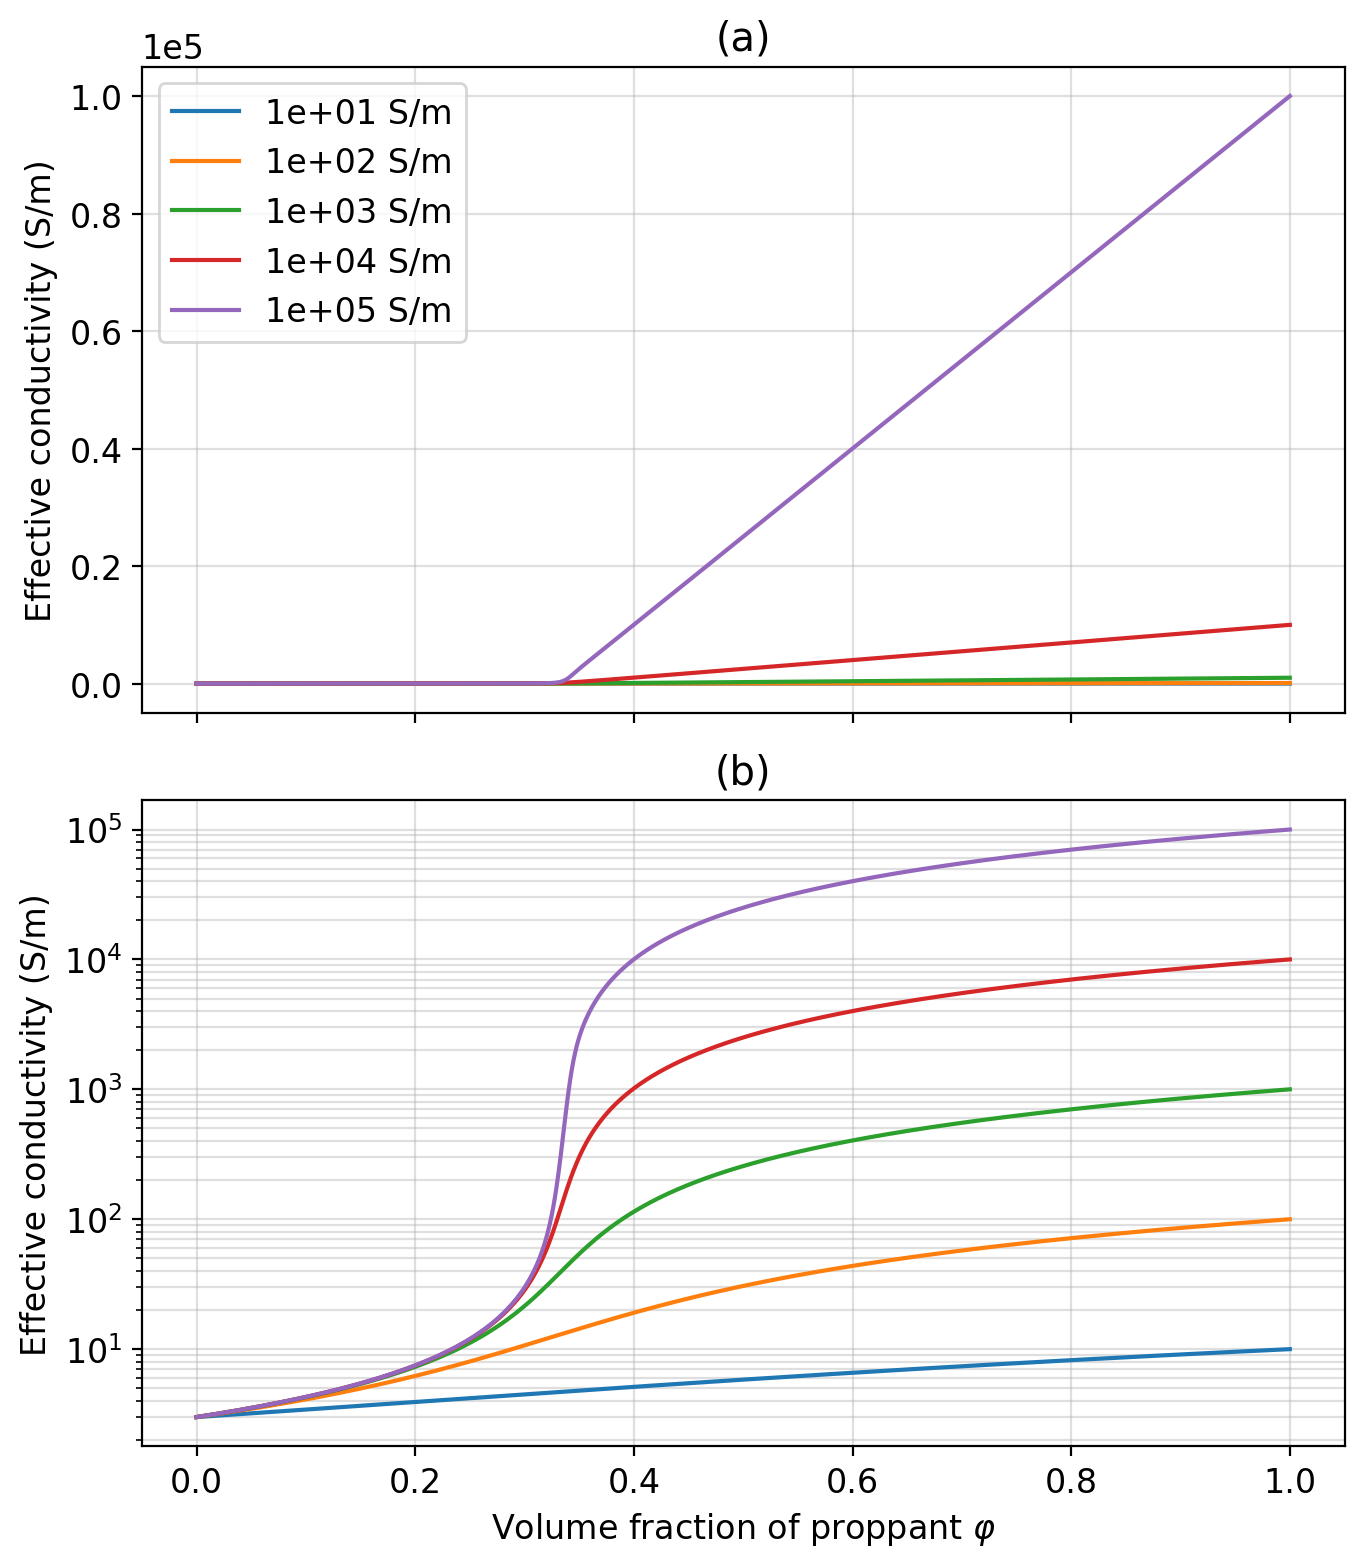

In [8]:
fig, ax = plt.subplots(2, 1, figsize=(7, 8), dpi=200)

ax[1].semilogy(phi, sige)
ax[0].plot(phi, sige)
ax[0].ticklabel_format(style='sci', axis='y', scilimits=(0,0)) 

for i, a in enumerate(ax):
    a.grid(which="both", alpha=0.4)
    a.set_xlabel("Volume fraction of proppant $\\varphi$")
    a.set_ylabel("Effective conductivity (S/m)")
    a.set_title("({})".format(ascii_lowercase[i]))
    
    if i == 0:
        a.set_xlabel('')
        a.set_xticklabels(['']*len(a.get_xticklabels()))
        a.legend(["{:1.0e} S/m".format(s) for s in sigma1])
plt.tight_layout()

fig.savefig("../figures/emt_spherical_particles", dpi=200, bbox_inches="tight")

## Vary the conductivity of the fluid

**Figure 2.4** Impact of the conductivity of the fluid on the effective conductivity of a proppant-fluid mixture. Panels (a) and (c) show the effective conductivity for mixtures with a $10^3$ S/m proppant and panels (b) and (d) show the effective conductivity for mixtures with a $10^4$ S/m proppant. The conductivity of the fluid is indicated by the legend.

In [9]:
scemt = Maps.SelfConsistentEffectiveMedium(sigma0=sigma_fluid, sigma1=sigma_proppant_default)

In [10]:
sigma0 = np.r_[0.3, 3, 30, 300]
sigma1 = np.r_[1e3, 1e4]
phi = np.linspace(0.0, 1, 1000) # vary the volume of proppant

In [11]:
sige = np.zeros([phi.size, sigma0.size, sigma1.size])

for j, sp in enumerate(sigma1):
    scemt.sigma1 = sp
    for i, s in enumerate(sigma0):
        scemt.sigma0 = s
        sige[:, i, j] = scemt * phi

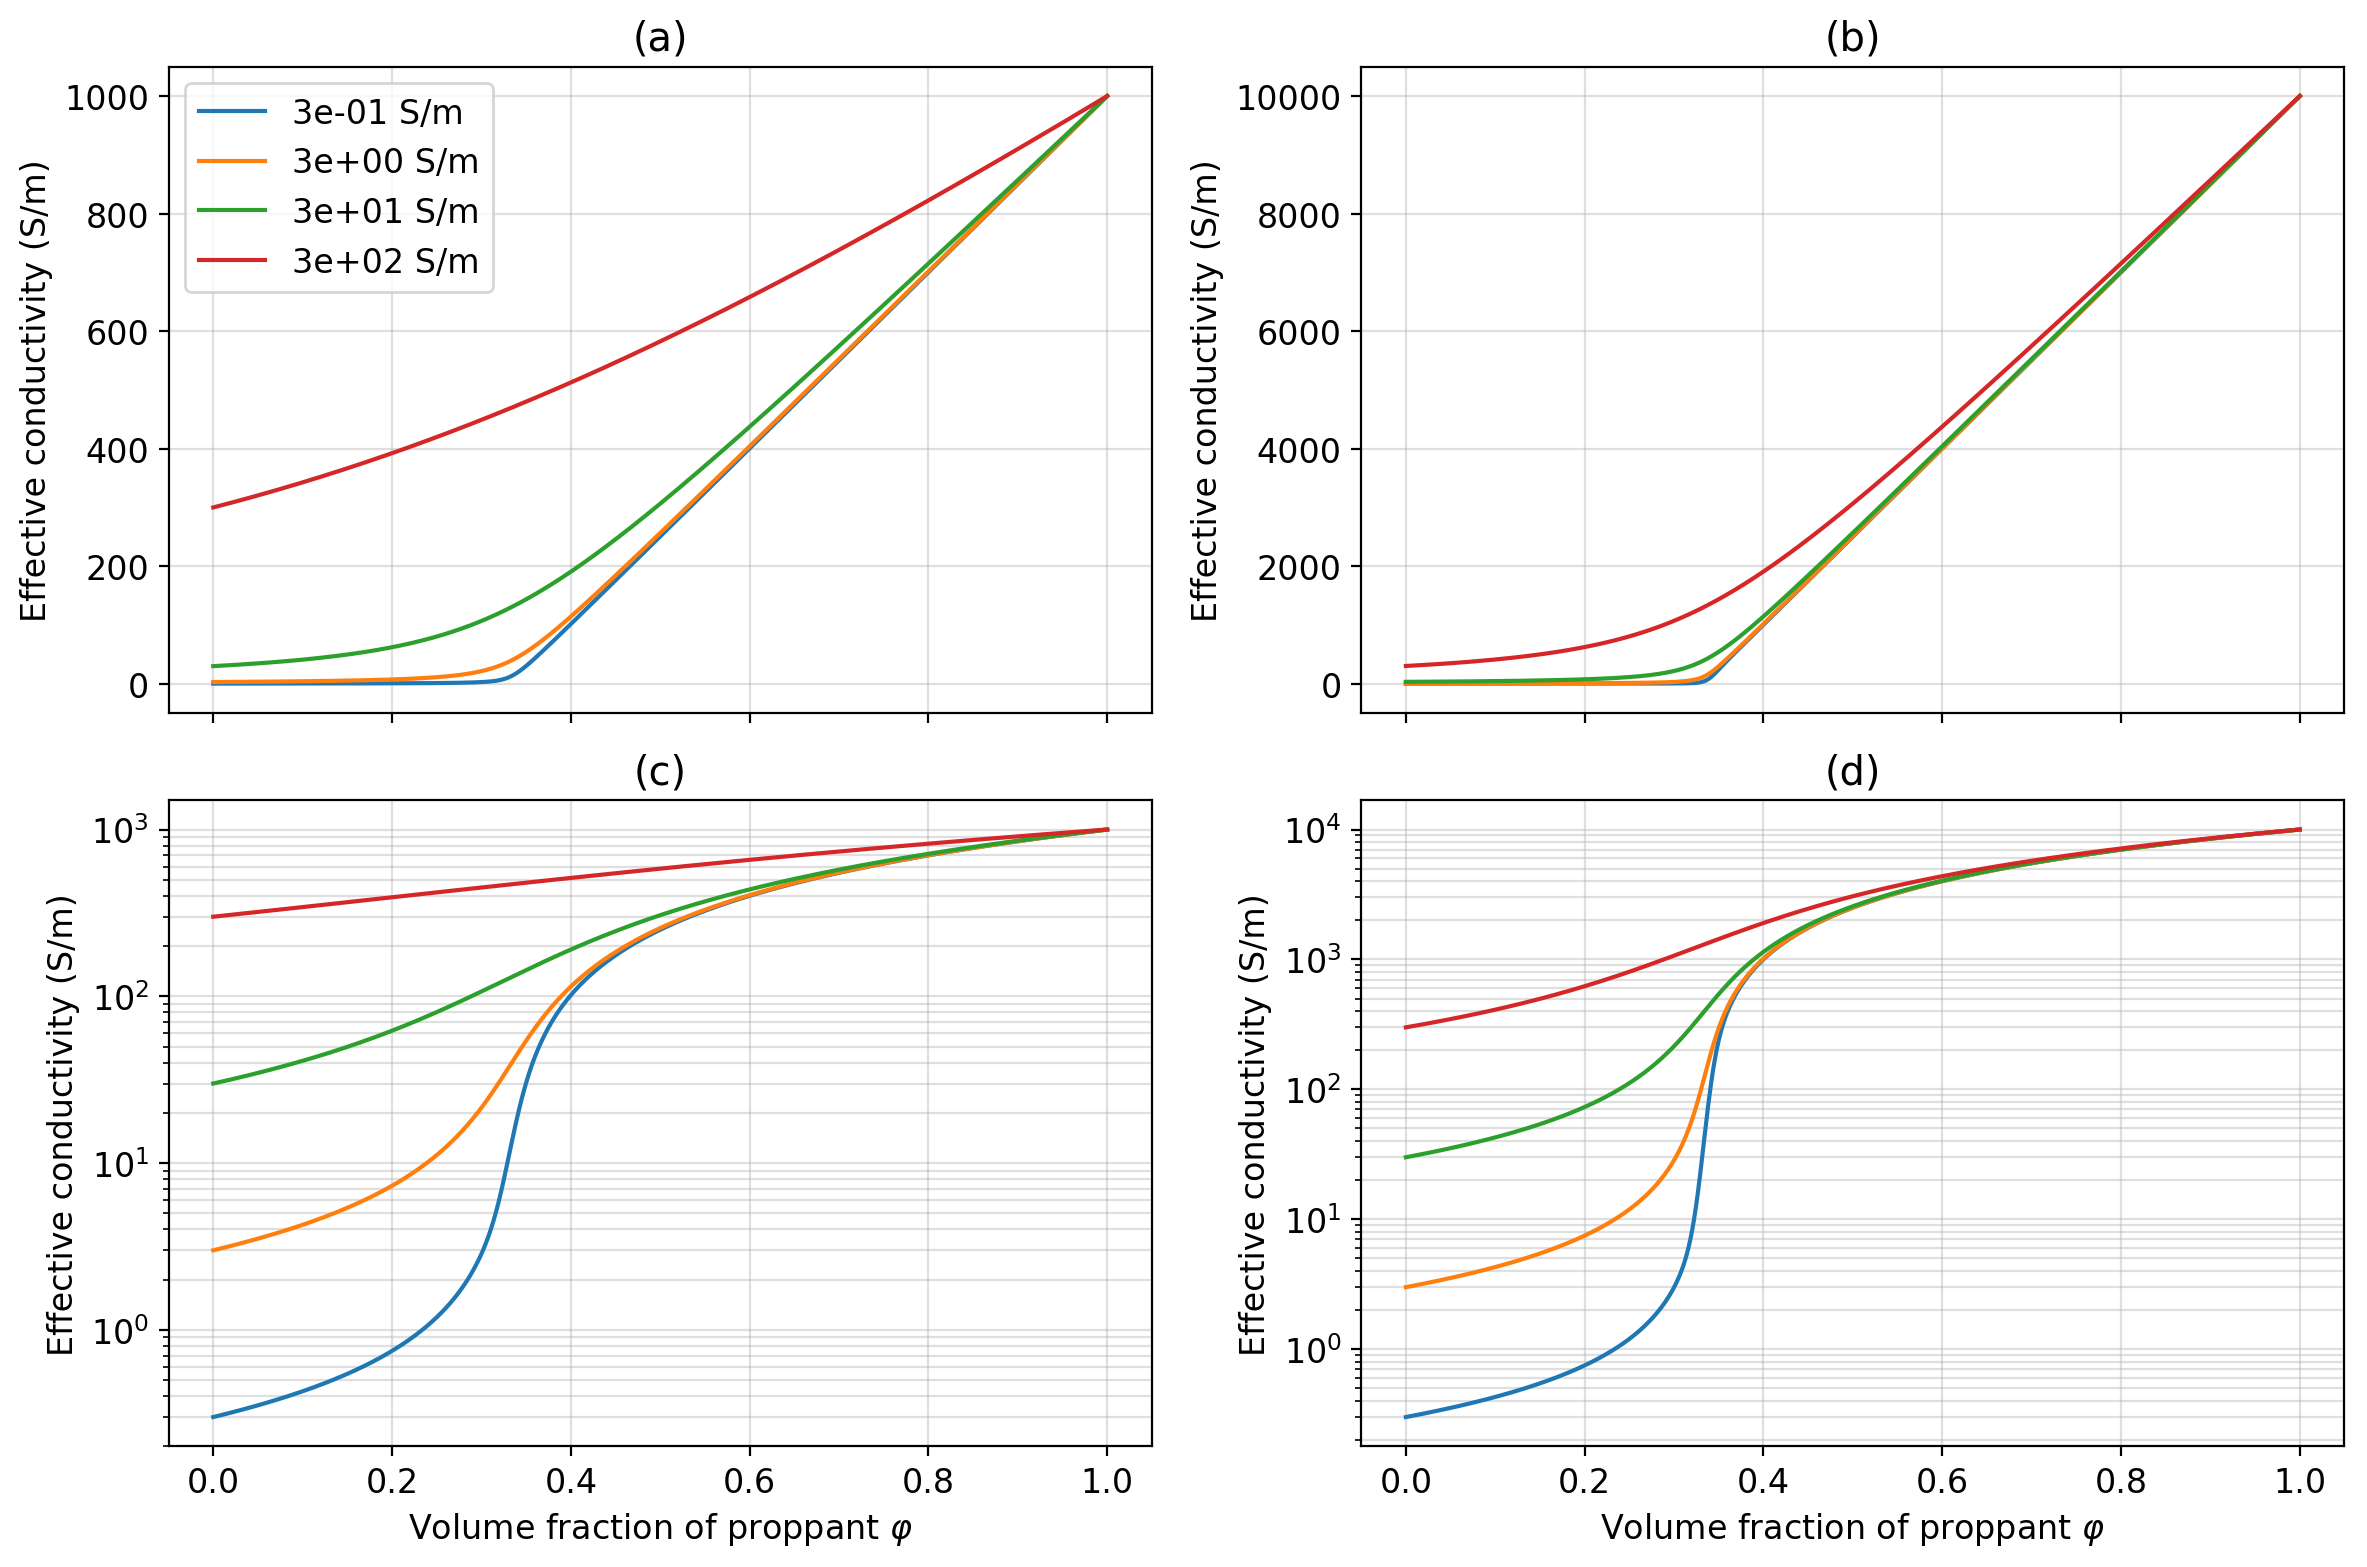

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8), dpi=200)


for j in range(len(sigma1)):

    ax[0, j].plot(phi, sige[:, :, j])
    ax[0, j].grid(which="both", alpha=0.4)
    ax[0, j].set_ylabel("Effective conductivity (S/m)")
    ax[0, j].set_xlabel("Volume fraction of proppant $\\varphi$")
    
    ax[1, j].semilogy(phi, sige[:, :, j])
    ax[1, j].grid(which="both", alpha=0.4)
#     ax[1, j].legend(["{:1.0e} S/m".format(s) for s in sigma0])
    ax[1, j].set_xlabel("Volume fraction of proppant $\\varphi$")
    ax[1, j].set_ylabel("Effective conductivity (S/m)")
    
for a in ax[0, :]:
    a.set_xlabel('')
    a.set_xticklabels(['']*len(a.get_xticklabels()))
#     a.legend(["{:1.0e} S/m".format(s) for s in sigma1])

    

ax[0, 0].legend(["{:1.0e} S/m".format(s) for s in sigma0])
[a.set_title("({})".format(ascii_lowercase[i])) for i, a in enumerate(ax.flatten())]

plt.tight_layout()

fig.savefig("../figures/emt_fluid", dpi=200, bbox_inches="tight")

## 3 phase EMT
- conventional, resistive proppant with conductive, spherical proppant in conductive fluid

**Figure 2.5** Effective conductivity of a 3-phase proppant-fluid mixure consisting of resistive proppant ($10^{−6}$ S/m), conductive proppant ($10^5$ S/m) and saline fluid (3 S/m). The legend indicates the percentage of conductive proppant in the proppant mixture and the x-axis is the volume fraction of proppant in the proppant-fluid mixture.

In [13]:
def multiphase_emt(phi, sigmas, alphas=None):
#     sigstart = scemt.wennerBounds(phi[0])[0]
    sige1 = np.min(sigmas)
    
    if alphas is None:
        alphas = np.ones(len(sigmas))

    for i in range(100):
        R = [scemt.getR(s, sige1, alp) for s, alp in zip(sigmas, alphas)]

        den = np.sum([p*r for p, r in zip(phi, R)], 0)  # phi0*R0 + phi1*R1
        num = np.sum([p*s*r for p, s, r in zip(phi, sigmas, R)], 0)  # phi0*scemt.sigma0*R0 + phi1*scemt.sigma1*R1

        sige2 = num/den
        relerr = np.abs(sige2-sige1)

        if np.all(relerr <= scemt.tol):
#             if scemt.sigstart is None:
#                 scemt.sigstart = sige2  # store as a starting point for the next time around
            return sige2

        sige1 = sige2
    # TODO: make this a proper warning, and output relevant info (sigma0, sigma1, phi, sigstart, and relerr)

    return sige2

In [14]:
sig_3phase = [sigma_fluid, 1e-6, sigma_proppant_default]
phi_cond_prop = [0, 0.25, 0.50, 0.75, 1.]
sige2 = np.zeros([phi.size, len(phi_cond_prop)])

for i, p in enumerate(phi_cond_prop):
    phi_pf = [1-phi, (1-p)*phi, p*phi]
    assert np.allclose(np.sum(phi_pf, 0), 1), "{}".format(np.sum(phi_pf, 0))
    sige2[:, i] = multiphase_emt(phi_pf, sig_3phase)

    

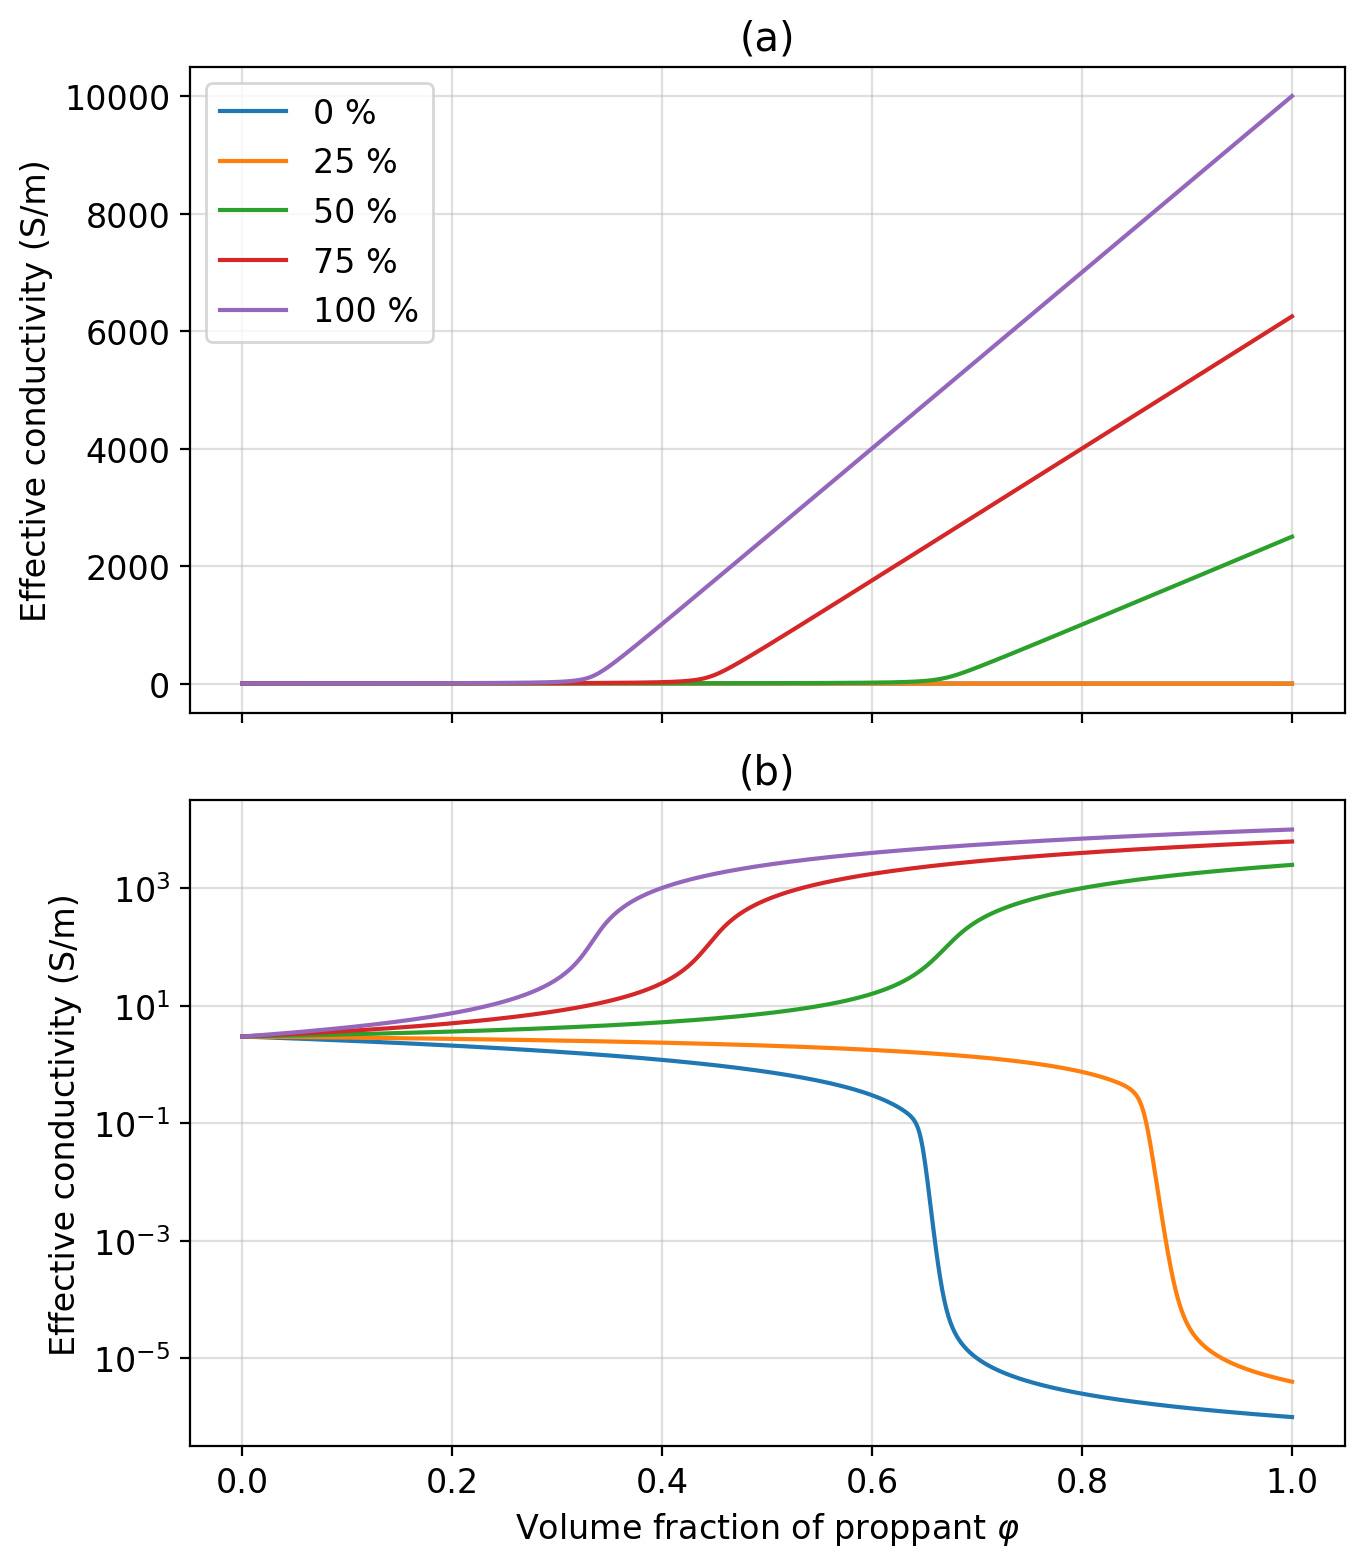

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(7, 8), dpi=200)

ax[0].plot(phi, sige2)
ax[1].semilogy(phi, sige2)

for i, a in enumerate(ax):
    a.grid(which="both", alpha=0.4)
    a.set_xlabel("Volume fraction of proppant $\\varphi$")
    a.set_ylabel("Effective conductivity (S/m)")
    a.set_title("({})".format(ascii_lowercase[i]))
    
    if i == 0:
        a.set_xlabel('')
        a.set_xticklabels(['']*len(a.get_xticklabels()))
#         a.legend(["{:1.0e} S/m".format(s) for s in sigma1])

ax[0].legend(["{:1.0f} %".format(p*100) for p in phi_cond_prop])
plt.tight_layout()

fig.savefig("../figures/emt_3phase", dpi=200, bbox_inches="tight")

## 3 phase with elongated particles
- conventional, resistive proppant with electrically conductive, elongated particles and conductive fluid 

**Figure 2.6** Effective conductivity of a 3-phase proppant-fluid mixure consisting of resistive proppant ($10^{−6}$ S/m), conductive proppant ($10^5$ S/m) and saline fluid (3 S/m). The proppant mixture contains 25% conductive proppant and 75% resistive proppant. The legend indicates the asppect ratio of the elongated conductive proppant filler (prolate spheroids).

In [16]:
sig_3phase = [3, 1e-6, 1e5]
p = 0.25
phi_pf = [1-phi, (1-p)*phi, p*phi]
aspect = [1, 2, 5, 10, 20, 50]
sige3 = np.zeros([phi.size, len(aspect)])

for i, a in enumerate(aspect):
    sige3[:, i] = multiphase_emt(phi_pf, sig_3phase, np.r_[1, 1, a])


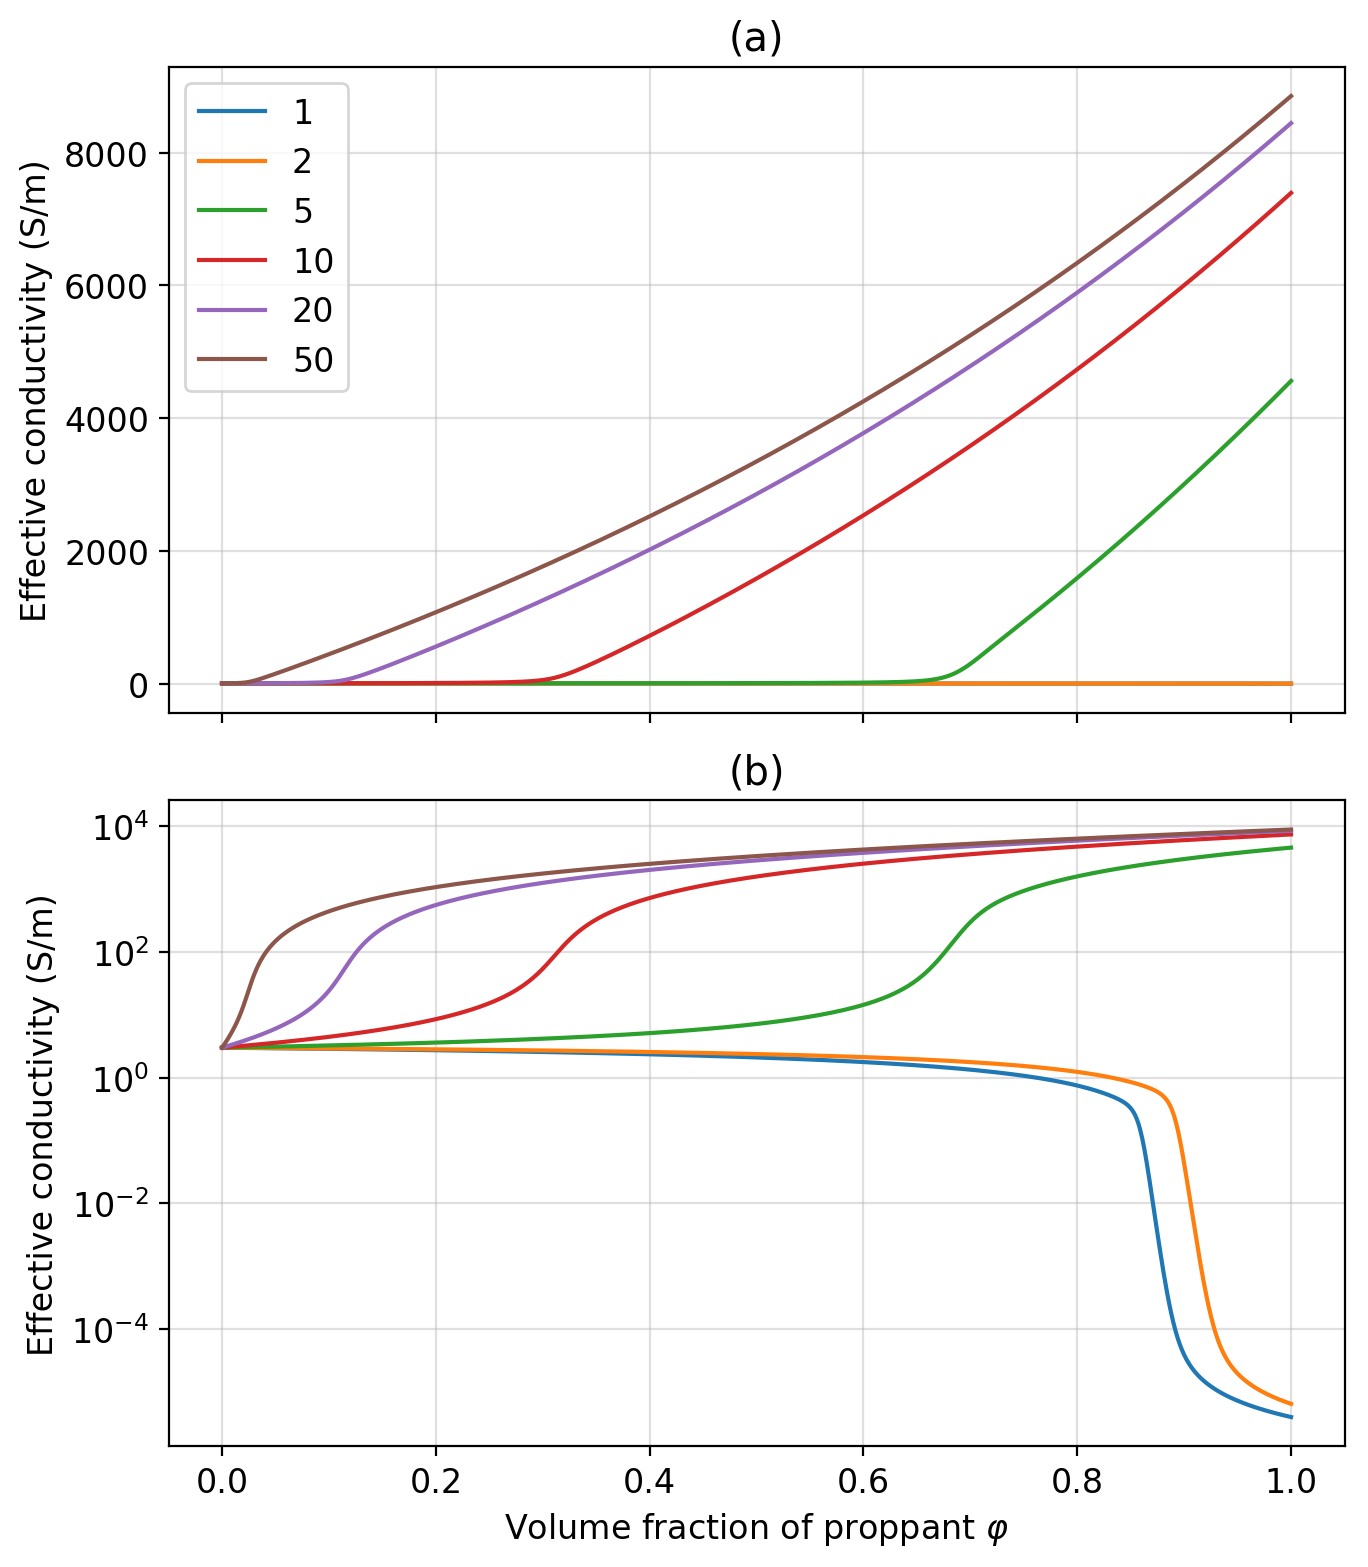

In [17]:
fig, ax = plt.subplots(2, 1, figsize=(7, 8), dpi=200)

ax[0].plot(phi, sige3)
ax[1].semilogy(phi, sige3)

for i, a in enumerate(ax):
    a.grid(which="both", alpha=0.4)
    a.set_xlabel("Volume fraction of proppant $\\varphi$")
    a.set_ylabel("Effective conductivity (S/m)")
    a.set_title("({})".format(ascii_lowercase[i]))
    
    if i == 0:
        a.set_xlabel('')
        a.set_xticklabels(['']*len(a.get_xticklabels()))

ax[0].legend(["{:1.0f}".format(a) for a in aspect])
plt.tight_layout()

fig.savefig("../figures/emt_3phase_aspect", dpi=200, bbox_inches="tight")

In [18]:
versions('HTML')